# Exercise 5 - Prediction Model

## Project Imports

In [0]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import scipy as sp
import pylab as P
import random

from sklearn.neighbors import KNeighborsClassifier

In [0]:

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
labels_dictionary = {0.0: "Blue",
                     1.0: "Brown",
                     2.0: "Green",
                     3.0: "Grey",
                     4.0: "Orange",
                     5.0: "Pink",
                     6.0: "Purple",
                     7.0: "Red",
                     8.0: "White",
                     9.0: "Yellow"}

# 1. Load the train dataset

##  First run "!ls" command to check if it's already in the vm

In [4]:
!mkdir BAK
!cp *.csv BAK/
!rm *.csv
!ls

mkdir: cannot create directory ‘BAK’: File exists
BAK  datalab


## Download the labeled dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '1mwrxBXZsgHLFO9IpWYXNfUFJnLT5yraj'})
downloaded.GetContentFile('train_X.csv')

downloaded = drive.CreateFile({'id': '1FHPumn9bdXiLzO5tbpGGrcvxzNpoCG0Z'})
downloaded.GetContentFile('train_y.csv')

## Load the train set into dataframes (X, y)

In [0]:
train_X = pd.read_csv("train_X.csv", header=0)
train_y = pd.read_csv("train_y.csv", header=None)
train_y.columns = ["Vote"]

train_y_values = train_y["Vote"]

## View the loaded training set

In [7]:
train_X.info()
train_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  5831 non-null float64
Yearly_IncomeK                                   5831 non-null float64
Overall_happiness_score                          5831 non-null float64
Avg_Satisfaction_with_previous_vote              5831 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    5831 non-null float64
Weighted_education_rank                          5831 non-null float64
Will_vote_only_large_party_1.0                   5831 non-null int64
Will_vote_only_large_party_0.0                   5831 non-null int64
Will_vote_only_large_party_2.0                   5831 non-null int64
Most_Important_Issue_4.0                         5831 non-null int64
Most_Important_Issue_1.0                         5831 non-null int64
Most_Important_Issue_7.0                         5831 non-null int64
Most_Important_Issue_5.0                         5831

,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_1.0,Most_Important_Issue_7.0,Most_Important_Issue_5.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_6.0,Most_Important_Issue_3.0
0,9.0,-1.135556,-4.210137,2.806640,-0.919437,3.395327,0,0,1,0,0,0,0,1,0,0,0
1,14.0,-0.674079,0.886686,1.802433,-0.102686,-0.133469,0,0,1,0,0,0,0,0,1,0,0
2,8.0,-0.965695,0.340745,-0.450976,0.477329,-0.416028,0,1,0,0,0,0,1,0,0,0,0
3,6.0,-0.093311,-0.093619,-0.650299,0.733155,-1.309064,1,0,0,0,0,0,0,1,0,0,0
4,6.0,2.259453,0.146151,0.304831,2.579338,0.818161,1,0,0,0,0,1,0,0,0,0,0


In [8]:
train_y.info()
train_y.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 1 columns):
Vote    5831 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB


,Vote
0,0.0
1,0.0
2,4.0
3,1.0
4,5.0


# 2. Train the learning models 

Models:
-------
1.   MLP - Multi Layer Perceptron - Discriminative
2.   Random Forest - Discriminative
3.   KNN - K Nearest Neighbors - Discriminative
4.   SVC - Support Vector Machine (Classifier) - Discriminative
5.   GradientBoosting - Boosting Model - Discriminative
6.   Linear Logistic Regression - Discriminative
7.   LDA - Linear Discriminant Analysis - Generative
8.   GNB - Naive Bayes - Generative

Ensemble:
---------
Pick the majority of votes - VotingClassifier 

## Train model via cross-validation on the train dataset, maximize performance and avoiding overfit

### Utility Methods

In [0]:
import operator

def get_model_best_scoring_method(scores_dictionary):
  return max(scores_dictionary.iteritems(), key=operator.itemgetter(1))[0]
  
def get_model_best_score(scores_dictionary):
  return scores_dictionary[max(scores_dictionary.iteritems(), key=operator.itemgetter(1))[0]][0]

def get_model_best_configuration(scores_dictionary):
  return scores_dictionary[max(scores_dictionary.iteritems(), key=operator.itemgetter(1))[0]][1]

In [0]:
def show_model_results(model_name, scores_dictionary):
  model_best_score = get_model_best_score(scores_dict)
  model_best_config = get_model_best_configuration(scores_dict)
  model_best_scoring_method = get_model_best_scoring_method(scores_dict)
  
  print "Best scoring method: {0}".format(model_best_scoring_method)
  print "Max score for {0} classifier model: {1}".format(model_name, model_best_score)
  print "Model best configuration: {0}".format(model_best_config)
  
  return (model_best_score, model_best_config)

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Notice - weighted is a form of macro which take to account for label imbalance
#scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scoring = ['accuracy', 'precision_weighted']

def parameter_estimation_gridsearch_cv(X, y, estimator, tuned_parameters, k_fold=10):
  score_best_parameters = {}
  for score in scoring:
    print "# Tuning parameters for scoring method: {0}".format(score)
    print ""
    #clf = GridSearchCV(estimator, tuned_parameters, cv=k_fold, scoring=score)
    clf = GridSearchCV(estimator, tuned_parameters, cv=StratifiedKFold(n_splits=k_fold), scoring=score)
    clf.fit(X, y)
    print "Best parameters set found on development set: {0}, with score: {1}".format(clf.best_params_, clf.best_score_)
    print ""
    print "Grid scores on development set:"  
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print ""
    print "The model is trained on the development set."
    true_y, pred_y = y, clf.predict(X)
    print "The scores are computed on the evaluation set."    
    print ""
    print "Detailed classification report:"
    print ""    
    print classification_report(true_y, pred_y)
    print ""
    print "Detailed confusion matrix:"
    print ""
    clf_confusion_matrix = confusion_matrix(true_y, pred_y)
    print clf_confusion_matrix
    print ""
    score_best_parameters[score] = (clf.best_score_, clf.best_params_, clf_confusion_matrix)
  return score_best_parameters 

In [0]:
def plot_parameter_evaluation(x_label, y_label, x_values, y_values):
  plt.plot(x_values, y_values)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

### Initialization

In [0]:
models_score_dictionary = {}
models_classifiers_dictionary = {}
models_classifiers_score = {}

use_default = True

### Model Training Methods

#### Optimize the model configuration using various scoring methods

In [0]:
def optimize_model_configuration(name, X, y, estimator, tuned_parameters):
  if use_default:
    return
  scores_dict = parameter_estimation_gridsearch_cv(X, y, estimator, tuned_parameters)
  model_best_score, model_best_config = show_model_results(name, scores_dict)
  models_score_dictionary[name] = (model_best_score, model_best_config)

#### Train the model with best configuration

In [0]:
def train_model(name, X, y, estimator):
  models_classifiers_dictionary[name] = estimator
  estimator.fit(X, y)
  score = estimator.score(X, y)
  models_classifiers_score[name] = round(score, 3)
  print "{0} Score: {1}".format(name, score)
  return estimator

## First Model: KNN - K Nearest Neighbors

In [16]:
from sklearn.neighbors import KNeighborsClassifier

tuned_parameters = {'n_neighbors': range(3, 15),
                    'algorithm': ['auto'],
                    'weights': ['uniform', 'distance']}
optimize_model_configuration("KNN", train_X, train_y, KNeighborsClassifier(), tuned_parameters)
knn = train_model("KNN", train_X, train_y_values, KNeighborsClassifier())

KNN Score: 0.948893843252


## Second Model: Multi Layer Perceptron    

In [17]:
from sklearn.neural_network import MLPClassifier

alpha_values = 10.0 ** -np.arange(1, 5)
tuned_parameters = {'hidden_layer_sizes': [(100,), (100, 17, 10,), (50, 25, 10,)],
                    'activation': ['relu'],
                    'alpha': alpha_values,
                    'learning_rate': ['constant', 'invscaling', 'adaptive']}
optimize_model_configuration("MLP", train_X, train_y, MLPClassifier(), tuned_parameters)
mlp = train_model("MLP", train_X, train_y_values, MLPClassifier())

MLP Score: 0.956268221574


## Third Model: Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {'n_estimators ': [5, 10, 25],
                    'criterion ': ['gini', 'entropy'],
                    'oob_score': [False, True]}

optimize_model_configuration("RF", train_X, train_y, RandomForestClassifier(), tuned_parameters)
rf = train_model("RF", train_X, train_y_values, RandomForestClassifier())

RF Score: 0.995712570743


## Forth Model: Linear SVC

In [19]:
from sklearn.svm import SVC

C_start, C_end, C_step = -3, 10, 2
C_values = 2. ** np.arange(C_start, C_end + C_step, C_step)
tuned_parameters = {'penalty': ['l1', 'l2'],
                    'class_weight': [None, 'balanced'],
                    'dual': [False, True],
                    'C': C_values}

optimize_model_configuration("SVC", train_X, train_y, SVC(probability=True), tuned_parameters)
svc = train_model("SVC", train_X, train_y_values, SVC(probability=True))

SVC Score: 0.93620305265


## Fifth Model: Gradient Boosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

tuned_parameters = {'n_estimators': [25, 50, 100, 1000],
                    'loss': ['deviance', 'exponential']}

optimize_model_configuration("GBC", train_X, train_y_values, GradientBoostingClassifier(), tuned_parameters)
gbc = train_model("GBC", train_X, train_y_values, GradientBoostingClassifier())

GBC Score: 0.993140113188


## Sixth Model: Logistic Regression

In [21]:
"""
from sklearn.linear_model import LogisticRegression

C_start, C_end, C_step = -3, 10, 2
C_values = 2. ** np.arange(C_start, C_end + C_step, C_step)
tuned_parameters = {'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
                    'multi_class': ['ovr', 'multinomial'],
                    'C': C_values}

optimize_model_configuration("LLR", train_X, train_y, LogisticRegression(), tuned_parameters)
llr = train_model("LLR", train_X, train_y_values, LogisticRegression())
"""

'\nfrom sklearn.linear_model import LogisticRegression\n\nC_start, C_end, C_step = -3, 10, 2\nC_values = 2. ** np.arange(C_start, C_end + C_step, C_step)\ntuned_parameters = {\'solver\': [\'newton-cg\', \'sag\', \'saga\', \'lbfgs\'],\n                    \'multi_class\': [\'ovr\', \'multinomial\'],\n                    \'C\': C_values}\n\noptimize_model_configuration("LLR", train_X, train_y, LogisticRegression(), tuned_parameters)\nllr = train_model("LLR", train_X, train_y_values, LogisticRegression())\n'

## Seventh Model: Linear Discriminant Analysis

In [22]:
"""
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

tuned_parameters = {'reg_param': [0.0]}

optimize_model_configuration("LDA", train_X, train_y, LinearDiscriminantAnalysis(), tuned_parameters)
lda = train_model("LDA", train_X, train_y_values, LinearDiscriminantAnalysis())
"""

'\nfrom sklearn.discriminant_analysis import LinearDiscriminantAnalysis\n\ntuned_parameters = {\'reg_param\': [0.0]}\n\noptimize_model_configuration("LDA", train_X, train_y, LinearDiscriminantAnalysis(), tuned_parameters)\nlda = train_model("LDA", train_X, train_y_values, LinearDiscriminantAnalysis())\n'

## Eighth Model: Gaussian Naive Bayes


In [23]:
"""
from sklearn.naive_bayes import GaussianNB

values = []
values.append(None)
tuned_parameters = {'priors': values}

optimize_model_configuration("GNB", train_X, train_y, GaussianNB(), tuned_parameters)
gnb = train_model("GNB", train_X, train_y, GaussianNB())
"""

'\nfrom sklearn.naive_bayes import GaussianNB\n\nvalues = []\nvalues.append(None)\ntuned_parameters = {\'priors\': values}\n\noptimize_model_configuration("GNB", train_X, train_y, GaussianNB(), tuned_parameters)\ngnb = train_model("GNB", train_X, train_y, GaussianNB())\n'

## Build Ensemble Voting Classifier 

In [24]:
from sklearn.ensemble import VotingClassifier

estimators = [(name, clf) for name, clf in models_classifiers_dictionary.iteritems()]
print estimators

[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)), ('MLP', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=

In [25]:
clf_hard = VotingClassifier(estimators=estimators, voting='hard')
clf_hard.fit(train_X, train_y_values)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='dev...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

# 3. Load the prepared valid dataset

## Download the valid dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '1HgtZC1iq9VYH8Ygo6-6XnC6G0xa8Lz01'})
downloaded.GetContentFile('valid_X.csv')

downloaded = drive.CreateFile({'id': '1Z_0zOORoZJVlOQ58UdXml4maSNSNBBMK'})
downloaded.GetContentFile('valid_y.csv')

In [27]:
!ls

BAK  datalab  train_X.csv  train_y.csv	valid_X.csv  valid_y.csv


## Load the valid dataset into dataframes (X, y)

In [0]:
valid_X = pd.read_csv("valid_X.csv", header=0)
valid_y = pd.read_csv("valid_y.csv", header=None)
valid_y.columns = ["Vote"]

valid_y_values = valid_y["Vote"]

## View the loaded valid dataset

In [29]:
valid_X.info()
valid_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  1944 non-null float64
Yearly_IncomeK                                   1944 non-null float64
Overall_happiness_score                          1944 non-null float64
Avg_Satisfaction_with_previous_vote              1944 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    1944 non-null float64
Weighted_education_rank                          1944 non-null float64
Will_vote_only_large_party_1.0                   1944 non-null int64
Will_vote_only_large_party_0.0                   1944 non-null int64
Will_vote_only_large_party_2.0                   1944 non-null int64
Most_Important_Issue_4.0                         1944 non-null int64
Most_Important_Issue_1.0                         1944 non-null int64
Most_Important_Issue_7.0                         1944 non-null int64
Most_Important_Issue_5.0                         1944

,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_1.0,Most_Important_Issue_7.0,Most_Important_Issue_5.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_6.0,Most_Important_Issue_3.0
0,12.0,-0.107043,-0.141038,0.691124,-0.480667,-0.275633,1,0,0,0,1,0,0,0,0,0,0
1,8.0,1.872975,-0.189318,-0.721718,1.867954,-0.110044,1,0,0,0,0,1,0,0,0,0,0
2,12.0,0.788380,1.631465,0.520939,-0.703350,0.511250,1,0,0,0,0,0,0,1,0,0,0
3,8.0,-0.098471,0.059599,0.688121,0.682170,-1.322242,1,0,0,1,0,0,0,0,0,0,0
4,9.0,-0.042849,0.565714,0.591769,-0.113672,-0.630451,1,0,0,0,0,1,0,0,0,0,0


In [30]:
valid_y.info()
valid_y.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 1 columns):
Vote    1944 non-null float64
dtypes: float64(1)
memory usage: 15.3 KB


,Vote
0,6.0
1,5.0
2,2.0
3,8.0
4,6.0


# 4. Check trained ensemble model on the valid dataset and check performance

## Utility methods

In [0]:
classes_names = ["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0", "8.0", "9.0"]

In [0]:
from sklearn.multiclass import OneVsRestClassifier

models_prediction_dictionary = {}
models_accuracy_dictionary = {}

def group_by_count(list):
  result = {}
  for item in list:
    if item in result:
      result[item] += 1
    else:
      result[item] = 1
  return result

def display_parties_count(y):
  parties_samples = group_by_count(y)
  print "Party | Count"
  print "----- | -----"
  for party, count in parties_samples.iteritems():
    print "{0}   | {1}".format(party, count)
  print "----- | -----"
  print "Total | {0}".format(len(y))

def predict_model_labels(model_name, classifier, X, y):
  predictions = classifier.predict(X)
  accuracy = classifier.score(X, y)
  print "{0} Score: {1}".format(model_name, accuracy)
  models_accuracy_dictionary[model_name] = accuracy
  models_prediction_dictionary[model_name] = predictions
  return predictions

In [0]:
def estimators_prediction_stats(estimators_dictionary, ensemble_estimator, X, y):
  estimators_predictions = {}
  
  #estimators_predictions["Label"] = (group_by_count(y), 1.0)
  label_stats = group_by_count(y)
  predictions = ensemble_estimator.predict(X)
  estimators_predictions["Ensemble"] = (group_by_count(predictions), round(ensemble_estimator.score(X, y), 3))
  
  for name, clf in estimators_dictionary.iteritems():
    predictions = clf.predict(X)
    predicted_parties_stats = group_by_count(predictions)
    estimators_predictions[name] = (predicted_parties_stats, models_classifiers_score[name])
    
  headers = "Party | {0:10} ".format("Label")
  space = "-" * 5 + " | " + "-" * 10 + " "
  for name in estimators_predictions.keys():
    headers += "| {0:10} ".format(name)
    space += "| " + "-" * 10 + " "
  print headers
  print space
  for label in labels_dictionary.keys():
    label_line = "{0:5} | {1:10} ".format(label, label_stats[label])
    for stats in estimators_predictions.values():
      label_line += "| {0:10} ".format(stats[0][label])
    print label_line
  print space
  scores = "Score | {0:10} ".format(1.0)
  for stats in estimators_predictions.values():
      scores += "| {0:10} ".format(stats[1])
  print scores   

## Predict labels using the trained model on the valid dataset

In [34]:
print models_classifiers_dictionary
print models_classifiers_score

{'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), 'GBC': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), 'MLP': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True,

In [35]:
estimators_prediction_stats(models_classifiers_dictionary, clf_hard, valid_X, valid_y_values)
predictions = predict_model_labels("EnsembleVoting", clf_hard, valid_X, valid_y_values)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Party | Label      | KNN        | GBC        | RF         | SVC        | MLP        | Ensemble   
----- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- 
  0.0 |        162 |        162 |        163 |        170 |        169 |        165 |        172 
  1.0 |        372 |        414 |        396 |        413 |        440 |        412 |        417 
  2.0 |        326 |        334 |        324 |        327 |        327 |        327 |        327 
  3.0 |        110 |        103 |        110 |        109 |        105 |        109 |        106 
  4.0 |        107 |         96 |        104 |        108 |        116 |        109 |        111 
  5.0 |        209 |        192 |        193 |        185 |        165 |        182 |        180 
  6.0 |        413 |        414 |        413 |        415 |        414 |        411 |        414 
  7.0 |        108 |        126 |        111 |        108 |        104 |        107 |        108 
  8.0 |         67 |

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


EnsembleVoting Score: 0.950102880658


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Performance measure (multiple measures)

###Utility Methods

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print title
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + " Plot")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import accuracy_score

def check_accuracy_score(prediction_dictionary, y):
  print "Performance measure calculation using Accuracy classification score:"
  print "--------------------------------------------------------------------"
  for model_name, model_prediction in prediction_dictionary.iteritems():
    result = accuracy_score(y, model_prediction)
    print "{0} Accuracy classification score result: {1}".format(model_name, result)

In [0]:
from sklearn.metrics import confusion_matrix

def check_confusion_matrix(prediction_dictionary, y):
  print "Performance measure calculation using Confusion Matrix:"
  print "-------------------------------------------------------"
  for model_name, model_prediction in prediction_dictionary.iteritems():  
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y, model_prediction)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize = (6,6))
    plot_confusion_matrix(conf_matrix, classes_names, False, "{0} Confusion Matrix".format(model_name), plt.cm.Blues)
    plt.show()

    # Plot normalized confusion matrix
    plt.figure(figsize = (6,6))
    plot_confusion_matrix(conf_matrix, classes_names, True, "{0} Normalized Confusion Matrix".format(model_name), plt.cm.Reds)
    plt.show()

In [0]:
from sklearn.metrics import classification_report

def check_classification_report(prediction_dictionary, y):
  print "Performance measure calculation using Classification Report:"
  print "-------------------------------------------------------"
  for model_name, model_prediction in prediction_dictionary.iteritems():
    class_report = classification_report(y, model_prediction, target_names=classes_names)
    print "{0} Confusion Matrix".format(model_name)
    print class_report

###Accuracy classification score

In [40]:
check_accuracy_score(models_prediction_dictionary, valid_y)

Performance measure calculation using Accuracy classification score:
--------------------------------------------------------------------
EnsembleVoting Accuracy classification score result: 0.950102880658


###Confusion Matrix

Performance measure calculation using Confusion Matrix:
-------------------------------------------------------
EnsembleVoting Confusion Matrix
[[153   0   0   0   0   0   0   0   0   9]
 [  0 371   0   0   0   0   1   0   0   0]
 [  0   0 326   0   0   0   0   0   0   0]
 [  0   0   0 103   6   0   0   1   0   0]
 [  0   0   0   3 102   0   0   2   0   0]
 [  0  28   0   0   0 179   2   0   0   0]
 [  0   1   1   0   0   1 409   0   1   0]
 [  0   0   0   0   3   0   0 105   0   0]
 [  0  17   0   0   0   0   2   0  48   0]
 [ 19   0   0   0   0   0   0   0   0  51]]


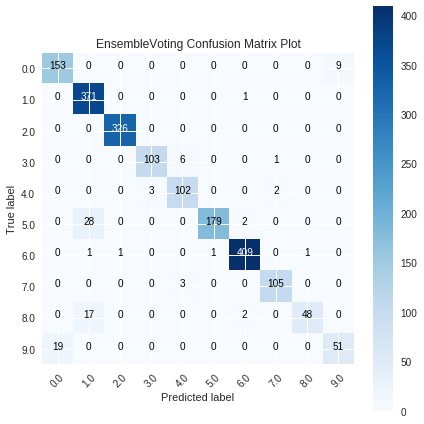

EnsembleVoting Normalized Confusion Matrix
[[0.94 0.   0.   0.   0.   0.   0.   0.   0.   0.06]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.94 0.05 0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.03 0.95 0.   0.   0.02 0.   0.  ]
 [0.   0.13 0.   0.   0.   0.86 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.   0.03 0.   0.   0.97 0.   0.  ]
 [0.   0.25 0.   0.   0.   0.   0.03 0.   0.72 0.  ]
 [0.27 0.   0.   0.   0.   0.   0.   0.   0.   0.73]]


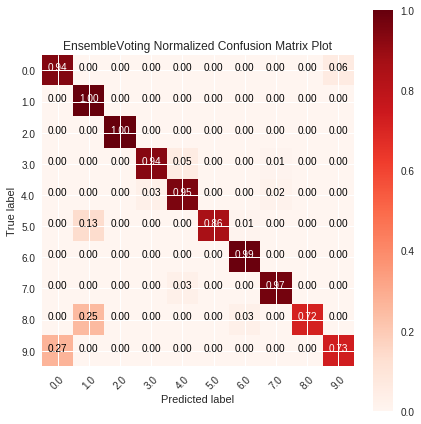

In [41]:
check_confusion_matrix(models_prediction_dictionary, valid_y)

###Classification Report

In [42]:
check_classification_report(models_prediction_dictionary, valid_y)

Performance measure calculation using Classification Report:
-------------------------------------------------------
EnsembleVoting Confusion Matrix
             precision    recall  f1-score   support

        0.0       0.89      0.94      0.92       162
        1.0       0.89      1.00      0.94       372
        2.0       1.00      1.00      1.00       326
        3.0       0.97      0.94      0.95       110
        4.0       0.92      0.95      0.94       107
        5.0       0.99      0.86      0.92       209
        6.0       0.99      0.99      0.99       413
        7.0       0.97      0.97      0.97       108
        8.0       0.98      0.72      0.83        67
        9.0       0.85      0.73      0.78        70

avg / total       0.95      0.95      0.95      1944



# 5. Load the prepared test dataset

## Download the test dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '10F4pfym7OgqvT1xu6Bo27WqpZjsGhhih'})
downloaded.GetContentFile('test_X.csv')

downloaded = drive.CreateFile({'id': '1uGX6RQFot5gww3vExfpeg1GFR8ZMFYPX'})
downloaded.GetContentFile('test_y.csv')

In [44]:
!ls

BAK	 test_X.csv  train_X.csv  valid_X.csv
datalab  test_y.csv  train_y.csv  valid_y.csv


## Load the test dataset into dataframes (X, y)

In [0]:
test_X = pd.read_csv("test_X.csv", header=0)
test_y = pd.read_csv("test_y.csv", header=None)
test_y.columns = ["Vote"]

test_y_values = test_y["Vote"]

## View the loaded test dataset

In [46]:
test_X.info()
test_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  1944 non-null float64
Yearly_IncomeK                                   1944 non-null float64
Overall_happiness_score                          1944 non-null float64
Avg_Satisfaction_with_previous_vote              1944 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    1944 non-null float64
Weighted_education_rank                          1944 non-null float64
Will_vote_only_large_party_1.0                   1944 non-null int64
Will_vote_only_large_party_0.0                   1944 non-null int64
Will_vote_only_large_party_2.0                   1944 non-null int64
Most_Important_Issue_4.0                         1944 non-null int64
Most_Important_Issue_1.0                         1944 non-null int64
Most_Important_Issue_7.0                         1944 non-null int64
Most_Important_Issue_5.0                         1944

,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_1.0,Most_Important_Issue_7.0,Most_Important_Issue_5.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_6.0,Most_Important_Issue_3.0
0,9.0,-0.419086,0.210792,-0.230510,-0.060646,-0.564397,1,0,0,0,0,0,0,1,0,0,0
1,8.0,0.514930,-0.619711,1.107421,-0.130600,-0.651318,1,0,0,0,0,0,0,1,0,0,0
2,13.0,0.779048,1.696267,-0.448178,-0.847467,0.694600,1,0,0,0,0,1,0,0,0,0,0
3,12.0,0.263978,0.147911,-0.669467,0.528262,-1.566185,1,0,0,0,0,0,0,1,0,0,0
4,10.0,-0.287698,0.103872,-0.726453,0.389199,-1.081211,0,1,0,0,0,0,0,0,0,0,1


In [47]:
test_y.info()
test_y.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 1 columns):
Vote    1944 non-null float64
dtypes: float64(1)
memory usage: 15.3 KB


,Vote
0,6.0
1,6.0
2,2.0
3,6.0
4,7.0


# 6. Check trained model on the test dataset and check performance

## Predict labels using the trained model on the valid dataset

In [48]:
models_prediction_dictionary.clear()
estimators_prediction_stats(models_classifiers_dictionary, clf_hard, test_X, test_y_values)
predictions = predict_model_labels("EnsembleVoting", clf_hard, test_X, test_y_values)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Party | Label      | KNN        | GBC        | RF         | SVC        | MLP        | Ensemble   
----- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- 
  0.0 |        161 |        150 |        160 |        165 |        169 |        166 |        169 
  1.0 |        371 |        408 |        393 |        393 |        438 |        402 |        402 
  2.0 |        326 |        332 |        326 |        326 |        326 |        326 |        326 
  3.0 |        110 |        103 |        110 |        109 |         99 |        106 |        104 
  4.0 |        107 |        114 |        106 |        114 |        120 |        112 |        115 
  5.0 |        209 |        197 |        201 |        207 |        175 |        191 |        195 
  6.0 |        414 |        415 |        411 |        413 |        408 |        412 |        412 
  7.0 |        109 |        109 |        110 |        103 |        107 |        108 |        107 
  8.0 |         67 |

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


EnsembleVoting Score: 0.950102880658


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Performance measure (multiple measures)

###Accuracy classification score

In [49]:
check_accuracy_score(models_prediction_dictionary, test_y)

Performance measure calculation using Accuracy classification score:
--------------------------------------------------------------------
EnsembleVoting Accuracy classification score result: 0.950102880658


###Confusion Matrix

Performance measure calculation using Confusion Matrix:
-------------------------------------------------------
EnsembleVoting Confusion Matrix
[[152   0   0   0   0   0   1   0   0   8]
 [  0 366   0   0   0   2   1   0   2   0]
 [  0   0 326   0   0   0   0   0   0   0]
 [  0   0   0 102   3   0   0   5   0   0]
 [  0   0   0   1 105   0   0   1   0   0]
 [  0  21   0   0   0 185   3   0   0   0]
 [  0   3   0   0   0   5 406   0   0   0]
 [  0   0   0   1   7   0   0 101   0   0]
 [  0  12   0   0   0   3   1   0  51   0]
 [ 17   0   0   0   0   0   0   0   0  53]]


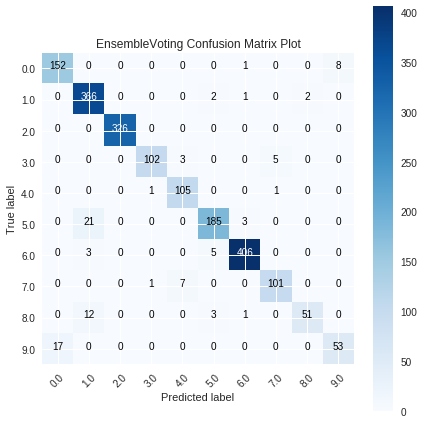

EnsembleVoting Normalized Confusion Matrix
[[0.94 0.   0.   0.   0.   0.   0.01 0.   0.   0.05]
 [0.   0.99 0.   0.   0.   0.01 0.   0.   0.01 0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.93 0.03 0.   0.   0.05 0.   0.  ]
 [0.   0.   0.   0.01 0.98 0.   0.   0.01 0.   0.  ]
 [0.   0.1  0.   0.   0.   0.89 0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.06 0.   0.   0.93 0.   0.  ]
 [0.   0.18 0.   0.   0.   0.04 0.01 0.   0.76 0.  ]
 [0.24 0.   0.   0.   0.   0.   0.   0.   0.   0.76]]


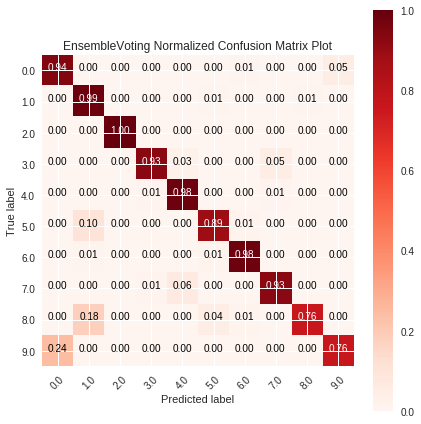

In [50]:
check_confusion_matrix(models_prediction_dictionary, test_y)

###Classification Report


In [51]:
check_classification_report(models_prediction_dictionary, test_y)

Performance measure calculation using Classification Report:
-------------------------------------------------------
EnsembleVoting Confusion Matrix
             precision    recall  f1-score   support

        0.0       0.90      0.94      0.92       161
        1.0       0.91      0.99      0.95       371
        2.0       1.00      1.00      1.00       326
        3.0       0.98      0.93      0.95       110
        4.0       0.91      0.98      0.95       107
        5.0       0.95      0.89      0.92       209
        6.0       0.99      0.98      0.98       414
        7.0       0.94      0.93      0.94       109
        8.0       0.96      0.76      0.85        67
        9.0       0.87      0.76      0.81        70

avg / total       0.95      0.95      0.95      1944



# 7. Load the unlabeled dataset

## Download the unlabeled dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '10wawksU1qEZ-fNWwEbE5gCDPjRVKPqFs'})
downloaded.GetContentFile('ElectionsData_Pred_Features_selected_features_after_preperation_one_hot.csv')

In [53]:
!ls

BAK
datalab
ElectionsData_Pred_Features_selected_features_after_preperation_one_hot.csv
test_X.csv
test_y.csv
train_X.csv
train_y.csv
valid_X.csv
valid_y.csv


## Load the unlabeled dataset into dataframe (X)

In [0]:
unlabeled_X = pd.read_csv("ElectionsData_Pred_Features_selected_features_after_preperation_one_hot.csv", header=0)

## View the loaded unlabeled dataset

In [55]:
unlabeled_X.info()
unlabeled_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
IdentityCard_Num                                 10000 non-null float64
Number_of_valued_Kneset_members                  10000 non-null float64
Yearly_IncomeK                                   10000 non-null float64
Overall_happiness_score                          10000 non-null float64
Avg_Satisfaction_with_previous_vote              10000 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    10000 non-null float64
Weighted_education_rank                          10000 non-null float64
Will_vote_only_large_party_1.0                   10000 non-null int64
Will_vote_only_large_party_0.0                   10000 non-null int64
Will_vote_only_large_party_2.0                   10000 non-null int64
Most_Important_Issue_4.0                         10000 non-null int64
Most_Important_Issue_5.0                         10000 non-null int64
Most_Important_Issue_1.0              

,IdentityCard_Num,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_5.0,Most_Important_Issue_1.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_3.0,Most_Important_Issue_7.0,Most_Important_Issue_6.0
0,1.0,8.0,-0.178662,-0.393790,0.176517,-0.498407,-0.149912,1,0,0,1,0,0,0,0,0,0,0
1,2.0,6.0,0.225238,-0.596577,0.071124,-0.422856,-0.271918,0,1,0,0,1,0,0,0,0,0,0
2,3.0,14.0,1.518685,0.695575,1.551261,-0.504231,-0.130677,0,0,1,0,0,1,0,0,0,0,0
3,4.0,5.0,-0.375136,-0.443474,-0.814019,-0.499401,-0.039032,1,0,0,0,0,0,1,0,0,0,0
4,5.0,15.0,1.089040,1.302127,-1.488676,-1.848972,1.429066,0,0,1,0,0,1,0,0,0,0,0


# 8. Using the trained model to predict elections result

## Utilities Methods

In [0]:
import operator

def get_parties_size(predicted_labels):
  parties_size = group_by_count(predicted_labels)
  return parties_size

def display_parties_votes(predicted_labels):
  display_parties_count(predicted_labels)

def get_winning_party(parties_size):
  winning_party = max(parties_size.iteritems(), key=operator.itemgetter(1))[0]
  print "Winning Party: {0} ({1})".format(winning_party, labels_dictionary[winning_party])
  return winning_party, labels_dictionary[winning_party]

def plot_parties_votes_pie(parties_size, pie_size=10):
  labels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
  colors = ["blue", "brown", "green", "grey", "orange", "pink", "purple", "red", "white", "yellow"]
  prediction_values = parties_size.values()

  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  ratio = 0.0
  explode = (ratio, ratio, ratio, ratio, ratio, ratio, ratio, ratio, ratio, ratio)

  fig1, ax1 = plt.subplots(figsize=(pie_size,pie_size))
  ax1.pie(prediction_values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()
  
def simulate_elections(predicted_labels, pie_size=10):
  parties_size = get_parties_size(predicted_labels)
  display_parties_votes(predicted_labels)
  print ""
  winning_party = get_winning_party(parties_size)
  plot_parties_votes_pie(parties_size, pie_size)

## Preperation

In [57]:
unlabeled_original = unlabeled_X.copy()
unlabeled_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
IdentityCard_Num                                 10000 non-null float64
Number_of_valued_Kneset_members                  10000 non-null float64
Yearly_IncomeK                                   10000 non-null float64
Overall_happiness_score                          10000 non-null float64
Avg_Satisfaction_with_previous_vote              10000 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    10000 non-null float64
Weighted_education_rank                          10000 non-null float64
Will_vote_only_large_party_1.0                   10000 non-null int64
Will_vote_only_large_party_0.0                   10000 non-null int64
Will_vote_only_large_party_2.0                   10000 non-null int64
Most_Important_Issue_4.0                         10000 non-null int64
Most_Important_Issue_5.0                         10000 non-null int64
Most_Important_Issue_1.0              

In [58]:
prepared_dataset = unlabeled_X.drop("IdentityCard_Num", axis=1)
prepared_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  10000 non-null float64
Yearly_IncomeK                                   10000 non-null float64
Overall_happiness_score                          10000 non-null float64
Avg_Satisfaction_with_previous_vote              10000 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    10000 non-null float64
Weighted_education_rank                          10000 non-null float64
Will_vote_only_large_party_1.0                   10000 non-null int64
Will_vote_only_large_party_0.0                   10000 non-null int64
Will_vote_only_large_party_2.0                   10000 non-null int64
Most_Important_Issue_4.0                         10000 non-null int64
Most_Important_Issue_5.0                         10000 non-null int64
Most_Important_Issue_1.0                         10000 non-null int64
Most_Important_Issue_2.0                

In [59]:
unlabeled_predictions = clf_hard.predict(prepared_dataset)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


##Predictions:
1.   Which party would win the majority of votes
2.   The division of votes between the various parties
3.   Vote of each voter in the new sample



Party | Count
----- | -----
0.0   | 935
1.0   | 1794
2.0   | 1031
3.0   | 684
4.0   | 490
5.0   | 1255
6.0   | 2634
7.0   | 555
8.0   | 206
9.0   | 416
----- | -----
Total | 10000

Winning Party: 6.0 (Purple)


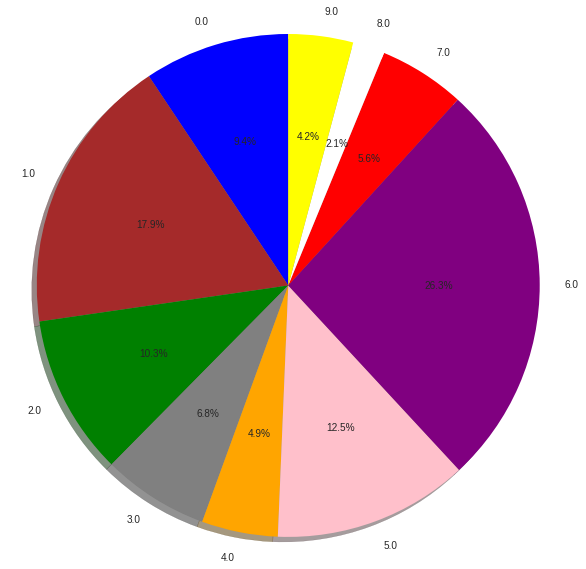

In [60]:
simulate_elections(unlabeled_predictions.tolist())

##Save voters predictions to the unlabeled dataset (IdentityCard_Num, PredictVote)

In [61]:
unlabeled_original["PredictVote"] = unlabeled_predictions
unlabeled_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
IdentityCard_Num                                 10000 non-null float64
Number_of_valued_Kneset_members                  10000 non-null float64
Yearly_IncomeK                                   10000 non-null float64
Overall_happiness_score                          10000 non-null float64
Avg_Satisfaction_with_previous_vote              10000 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    10000 non-null float64
Weighted_education_rank                          10000 non-null float64
Will_vote_only_large_party_1.0                   10000 non-null int64
Will_vote_only_large_party_0.0                   10000 non-null int64
Will_vote_only_large_party_2.0                   10000 non-null int64
Most_Important_Issue_4.0                         10000 non-null int64
Most_Important_Issue_5.0                         10000 non-null int64
Most_Important_Issue_1.0              

In [62]:
unlabeled_submit_dataset = unlabeled_original[["IdentityCard_Num", "PredictVote"]]
unlabeled_submit_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
IdentityCard_Num    10000 non-null float64
PredictVote         10000 non-null float64
dtypes: float64(2)
memory usage: 156.3 KB


In [0]:
# TODO: Convert party number to text throught - labels_dictionary
# 

unlabeled_submit_dataset.to_csv("ElectionsData_Pred_Features_Results.csv", index=False)
unlabeled_original.to_csv("ElectionsData_Pred_Features_Coalition.csv", index=False)

In [0]:
from google.colab import files

files.download("ElectionsData_Pred_Features_Results.csv")
files.download("ElectionsData_Pred_Features_Coalition.csv")

# Notes

In [0]:
# HERE ARE THE DATA SETS TO DOWNLOAD FROM DRIVE:

#ElectionsData.csv
#https://drive.google.com/open?id=1Xdsqn2C0XR8AQnRfkWpU2JBQfK2rURe_

## NEW AFTER FIX -1:

#test_X.csv
#https://drive.google.com/open?id=10F4pfym7OgqvT1xu6Bo27WqpZjsGhhih

#test_y.csv
#https://drive.google.com/open?id=1uGX6RQFot5gww3vExfpeg1GFR8ZMFYPX

#train_X.csv
#https://drive.google.com/open?id=1mwrxBXZsgHLFO9IpWYXNfUFJnLT5yraj

#train_y.csv
#https://drive.google.com/open?id=1FHPumn9bdXiLzO5tbpGGrcvxzNpoCG0Z

#validation_X.csv
#https://drive.google.com/open?id=1HgtZC1iq9VYH8Ygo6-6XnC6G0xa8Lz01

#validation_y.csv
#https://drive.google.com/open?id=1Z_0zOORoZJVlOQ58UdXml4maSNSNBBMK